In [1]:
import numpy as np
import pandas as pd
import io
import urllib.request

from matplotlib import pylab as plt

# Настройки matplotlib

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 16

## Блок часто используемых функций:
*Описание:* Здесь объявлены часто вызываемые функции, которые я часто использую в этом ноутбуке

In [31]:
def load_data(url, name):
    """
    Loading data

    Parameters
    ----------
    url : string
        url leading to data
    name : string
        name by which data will be stored in memory

    Returns
    -------
    DataFrame
        dataframe with loaded data
    """
    try:
        urllib.request.urlretrieve(url, name)
    except PermissionError:
        print('Data is already loaded')
    df = pd.read_csv(name)
    return df

def calc_w(A, y):
    """
    Calculate weights

    Parameters
    ----------
    A : numpy array
        matrix resulted from independent vector 
    y : numpy array
        vector of dependent values

    Returns
    -------
    numpy array
        numpy array with calculated weights
    """
    return (np.linalg.inv(A.T@A)@A.T).T@y

def _plot(x, y, y_pred = None, title = None, 
          plot_label = None, x_label = 'Время', y_label = 'Цена'):
    """
    Plots data and predicted function line if there is one (Captain, where is m boat?)

    Parameters
    ----------
    x : numpy array
        features
    y : numpy array
        vector of dependent values
    y_pred : numpy array
        vector of predicted values
    title : string
        plot name
    plot_label : string
        name of the line that will be shown in legend
    x_label : string
    y_label : string

    Returns
    -------
    None
    """    
    plt.scatter(x, y, label='', s = 10)
    
    if y_pred is not None:
        y_pred_std = [0,0]
        plt.plot(x, y_pred, color='black', linewidth=2, label=plot_label)
        for i in range(2,len(y_pred)-2):
            y_pred_std.append(np.std(y_pred[i-2:i+2]))
        y_pred_std.append(0)
        y_pred_std.append(0)
        plt.fill_between(x,y_pred - y_pred_std, y_pred + y_pred_std, label='Prediction')
        plt.legend()
        
    if title:
        plt.title(title, size = 26)
        
    plt.xlabel(x_label, size=16)
    plt.ylabel(y_label, size=16)
    plt.grid()
    plt.show()

## Цель вычислительного эксперимента

Необходимо решить задачу регрессии с использованием линейной регрессии, полиномиальной регрессии и/или криволинейной регрессии.  
**Метрика качества:** SSE - Sum of Squared Errors (Primary metrics), MSE - Mean Square Error, R2 - coefficient of determination

## Описание выборок
В эксперименте решается две задачи регрессии:  
  
 - **Задача 1:** предсказание цены на белый хлеб, использован датасет WhiteBreadPrices  
 (ссылка на датасет: https://sourceforge.net/p/mvr/code/HEAD/tree/data/WhiteBreadPrices.csv?format=raw)  

## Задача 1: Предсказание цены на хлеб  
  
*Описание задачи*: В этой задаче мы будем предсказывать цену на порезанный хлеб в зависимости от времени.  
Идейно код будет следовать за http://www.machinelearning.ru/wiki/index.php?title=Линейная_регрессия_%28пример%29

#### Шаг 1: Загрузим выборку

In [3]:
url = 'https://sourceforge.net/p/mvr/code/HEAD/tree/data/WhiteBreadPrices.csv?format=raw'
name = 'WhiteBreadPrices.csv'
df = load_data(url, name)
df.head()

,0.27723,0
0,0.29703,0.005155
1,0.21782,0.010309
2,0.12871,0.015464
3,0.31683,0.020619
4,0.34653,0.025773


Видим, что у датасета нет названий столбцов. Непорядок! Заглянем на сайт-источник и обнаружим, что именно имелось ввиду:  
>'The 1st column is the price of a loaf of bread;'  
>'the 2nd column is the time.'  

Изменим название столбцов в соответствии с полученной информацией

In [4]:
df.columns = ["Price", "time"]
df.head()

,Price,time
0,0.29703,0.005155
1,0.21782,0.010309
2,0.12871,0.015464
3,0.31683,0.020619
4,0.34653,0.025773


Выведем информацию о датасете:

In [5]:
print("Dataset has:")
print("  %s rows, %s feature" % (df.shape[0], int(df.shape[1] - 1)))
print("  %s unique feature values" % len(df['time'].unique()))
print("\nIs there any Nan or missing values?")
print(df.isna().sum())

Dataset has:
  194 rows, 1 feature
  194 unique feature values

Is there any Nan or missing values?
Price    0
time     0
dtype: int64


Всё в порядке. Можем приступать к визуализации данных

#### Шаг 2: Визуализация

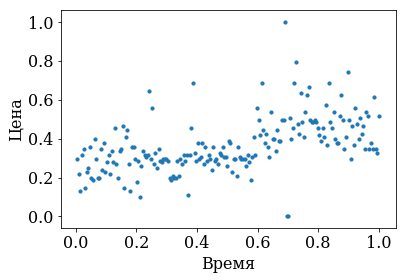

In [6]:
x = df.iloc[:, 1]
y = df.iloc[:, 0]
_plot(x, y)

#### Шаг 3: построение модели

**Одномерная регрессия**

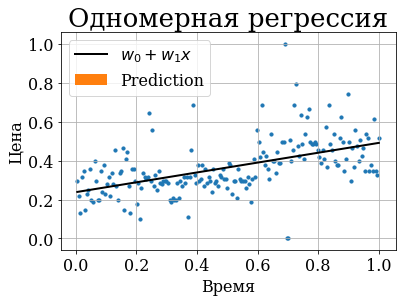

SSE: 2.731
MSE: 0.119
R2: -0.379


In [32]:
A = np.column_stack((np.ones(x.shape), x))
w = calc_w(A, y)
y_pred = A@w
delta_y = y - y_pred

_plot(x, y, y_pred, title = 'Одномерная регрессия', 
                    plot_label = '$w_{0}+w_{1}x$',
                    x_label = 'Время', y_label = 'Цена')

sse_value = delta_y.T@delta_y
mse_value = np.sqrt(np.mean(delta_y**2))
r2_value = 1 - np.sum((y - np.mean(y, axis = 0))**2)/sse_value
print("SSE: {:0.3f}\nMSE: {:0.3f}\nR2: {:0.3f}".format(sse_value, 
                                                       mse_value, 
                                                       r2_value))

**Полиномиальная регрессия**

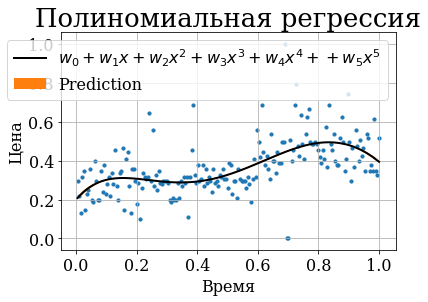

SSE: 2.489
MSE: 0.113
R2: -0.513


In [33]:
A = np.column_stack((np.ones(x.shape), x, x**2, x**3, x**4, x**5))
w = calc_w(A, y)
y_pred = A@w
delta_y = y - y_pred

_plot(x, y, y_pred, title = 'Полиномиальная регрессия', 
                    plot_label = '$w_{0}+w_{1}x+w_{2}x^{2}+w_{3}x^{3}+w_{4}x^{4}++w_{5}x^{5}$',
                    x_label = 'Время', y_label = 'Цена')

sse_value = delta_y.T@delta_y
mse_value = np.sqrt(np.mean(delta_y**2))
r2_value = 1 - np.sum((y - np.mean(y, axis = 0))**2)/sse_value
print("SSE: {:0.3f}\nMSE: {:0.3f}\nR2: {:0.3f}".format(sse_value, 
                                                       mse_value, 
                                                       r2_value))

**Криволинейная регрессия**

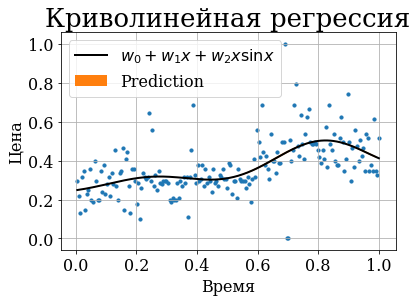

SSE: 2.486
MSE: 0.113
R2: -0.514


In [34]:
A = np.column_stack((np.ones(x.shape), x, x*np.sin(10*x)))
w = calc_w(A, y)
y_pred = A@w
delta_y = y - y_pred

_plot(x, y, y_pred, title = 'Криволинейная регрессия', 
                    plot_label = '$w_{0}+w_{1}x+w_{2}x{\sin x}$',
                    x_label = 'Время', y_label = 'Цена')

sse_value = delta_y.T@delta_y
mse_value = np.sqrt(np.mean(delta_y**2))
r2_value = 1 - np.sum((y - np.mean(y, axis = 0))**2)/sse_value
print("SSE: {:0.3f}\nMSE: {:0.3f}\nR2: {:0.3f}".format(sse_value, 
                                                       mse_value, 
                                                       r2_value))

Здесь мы видим, что криволинейная регрессия неплохо подходит для решения поставленной задачи, а вот дисперсия у предсказаний никакая.